In [1]:
using StatsBase
using GLM
using DataFrames
using Gadfly
using Cairo
using Fontconfig
using Formatting
using Compose, Colors

In [2]:
# get the data into a DataFrame

fulldf = DataFrame()

probnames = [:foo, :galid, :groupid, :cenid, :rband, :Psat, :Mh, :foo2, :foo3, :foo4, :projR, :projrad, :angRh]
corrnames = [:foo5, :galid, :M_r, :M_g, :cz, :Dn4000, :H_delta, :logsSFR, :stelM, :ra, :dec, :vdisp, :S2N, :sersic,
             :conc, :KplusA, :R_exp, :surfdens1kpc, :surfdensR_e, :surfdensR_eo2, :vdisp_err, :Bulge2Tlr, :B2T_err,
             :GMoR_e, :R_e]

probfiles = ["dat/clf_groups_M18_M9.4.prob", "dat/clf_groups_M19_M9.8.prob", "dat/clf_groups_M20_M10.3.prob"]
corrfiles = ["dat/clf_groups_M18_M9.4.galdata_corr", "dat/clf_groups_M19_M9.8.galdata_corr", "dat/clf_groups_M20_M10.2.galdata_corr"]
densfiles = ["dat/density_r10.M18_M9.4", "dat/density_r10.M19_M9.8", "dat/density_r10.M20_M10.3"]
randfiles = ["dat/drandom_r10.M18_M9.4", "dat/drandom_r10.M19_M9.8", "dat/drandom_r10.M20_M10.3"]

for i in 1:3
    
    # read the two catalogues in and join them on galaxy id
    probdf = readtable(probfiles[i], separator=' ', header=false)
    names!(probdf, probnames)
    corrdf = readtable(corrfiles[i], separator=' ', header=false)
    names!(corrdf, corrnames)
    
    # add a column for the density, corrected with the randoms
    density = readdlm(densfiles[i])
    rands = readdlm(randfiles[i])
    ρ_corr = 1.25 * (density[:, 1] ./ rands[:, 1])
    probdf[:ρ_env] = DataArray(ρ_corr)
    
    joindf = join(probdf, corrdf, on=:galid)
   
    if i == 1
        fulldf = joindf
    else
        fulldf = [fulldf; joindf]
    end
end

fulldf = unique(fulldf, :galid)
    

# remove any galaxies in environment density less than or equal to zero, to avoid computational issues
fulldf = fulldf[fulldf[:ρ_env] .> 0.0, :]

# remove bad measurements of R_e, vdisp (i.e. where they are zero)
fulldf = fulldf[fulldf[:R_e] .> 0.0, :]
fulldf = fulldf[fulldf[:vdisp] .> 0.0, :]


# Take only the quenched galaxies
fulldf = fulldf[fulldf[:Dn4000] .> 1.6, :]

# add a column for log10 of stellar mass and log of environment
fulldf[:log10M] = log10.(fulldf[:stelM])
fulldf[:logρ] = log10.(fulldf[:ρ_env])
fulldf[:logρ2] = fulldf[:logρ] .^ 2
fulldf[:logM2] = fulldf[:log10M] .^ 2

# Now take all the rows out which don't have central galaxies
fulldf = fulldf[fulldf[:Psat] .< 0.5, :]

writedlm("M18_mags.dat", fulldf[:M_r])
# And a new df for "pure" centrals
# puredf = fulldf[fulldf[:Psat] .< 0.01, :]

In [18]:
nbins = 5
maxM = maximum(fulldf[:log10M])
minM = minimum(fulldf[:log10M])
Medges = logspace(minM, maxM, nbins + 1)

fullmeans = []
fullmeds = []
puremeans = []
puremeds = []

# set a new column with mean logM for the colours in our plot
fulldf[:meanlogM] = zeros(nrow(fulldf))
for i in 1:nbins
    if i == nbins
        meanM = mean(fulldf[:log10M][log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1])])
        medianM = median(fulldf[:log10M][log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1])])
        fulldf[:meanlogM][log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1])] = meanM
    else    
        meanM = mean(fulldf[:log10M][log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1])])
        medianM = median(fulldf[:log10M][log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1])])
        fulldf[:meanlogM][log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1])] = meanM
    end
    append!(fullmeans, meanM)
    append!(fullmeds, medianM)
end

# same for the pure centrals dataframe
puredf[:meanlogM] = zeros(nrow(puredf))
for i in 1:nbins
    if i == nbins
        meanM = mean(puredf[:log10M][log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1])])
        medianM = median(puredf[:log10M][log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1])])
        puredf[:meanlogM][log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1])] = meanM
    else
        meanM = mean(puredf[:log10M][log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1])])
        medianM = median(puredf[:log10M][log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1])])
        puredf[:meanlogM][log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1])] = meanM
    end
    append!(puremeans, meanM)
    append!(puremeds, medianM)
end

In [19]:
# get the density bins to plot in
nrobins = 20
maxfro = maximum(fulldf[:logρ])
minfro = minimum(fulldf[:logρ])
frobins = linspace(minfro, maxfro, nrobins + 1)

fromeans = []
for i in 1:nrobins
    if i == nrobins
        meanro = mean(fulldf[:logρ][frobins[i] .<= fulldf[:logρ] .<= frobins[i + 1]])
    else    
        meanro = mean(fulldf[:logρ][frobins[i] .<= fulldf[:logρ] .< frobins[i + 1]])
    end
    append!(fromeans, meanro)
end

maxpro = maximum(puredf[:logρ])
minpro = minimum(puredf[:logρ])
probins = linspace(minpro, maxpro, nrobins + 1)

promeans = []
for i in 1:nrobins
    if i == nrobins
        meanro = mean(puredf[:logρ][probins[i] .<= puredf[:logρ] .<= probins[i + 1]])
    else    
        meanro = mean(puredf[:logρ][probins[i] .<= puredf[:logρ] .< probins[i + 1]])
    end
    append!(promeans, meanro)
end

In [20]:
function mean_center_logmass(vararr, logmass)
    
    nbins = 20
    maxM = maximum(logmass)
    minM = minimum(logmass)
    Medges = logspace(minM, maxM, nbins + 1)
    
    cenvar = zeros(length(vararr))
    
    for i in 1:nbins
        inds = log10(Medges[i]) .<= logmass .<= log10(Medges[i + 1])
        meanvar = mean(vararr[inds])
        cenvar[inds] = vararr[inds] / meanvar
    end

    return cenvar
end


function get_errbar(binpts)

    npts = length(binpts)
    ymean = mean(binpts)
    ystd = std(binpts)
    yerr = ystd / sqrt(npts)
    
    return ymean, yerr
end

get_errbar (generic function with 1 method)

In [21]:
function linmod(x, y, mod, errminmax)
    
    coeffs = coef(mod)
    fac = [1, sign(x), sign(y), sign(x) * sign(y)]
    
    if errminmax == "max"
        coeffs = coeffs .+ (fac .* stderr(mod))            
    elseif errminmax == "min"
        coeffs = coeffs .- (fac .* stderr(mod))
    end
    
    coeffs[1] + coeffs[2] * x + coeffs[3] * y + coeffs[4] * x * y
end
    
lmfull = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
                Estimate  Std.Error  t value Pr(>|t|)
(Intercept)     0.515981  0.0322113  16.0186   <1e-56
logρ            -0.33607  0.0633692 -5.30336    <1e-6
log10M          0.127633 0.00309397  41.2521   <1e-99
logρ & log10M  0.0345359 0.00608418  5.67635    <1e-7


In [22]:
lmpure = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
                Estimate  Std.Error  t value Pr(>|t|)
(Intercept)     0.504377   0.033866  14.8933   <1e-49
logρ             -0.3847  0.0684457 -5.62051    <1e-7
log10M           0.12872 0.00325137  39.5895   <1e-99
logρ & log10M  0.0391046 0.00656499  5.95654    <1e-8


In [23]:
function linmodsq(x, y, mod, errminmax)

    coeffs = coef(mod)
    fac = [1, sign(x), sign(y), 1, sign(x) * sign(y), sign(y)]
    
    if errminmax == "max"
        coeffs = coeffs .+ (fac .* stderr(mod))
    elseif errminmax == "min"
        coeffs = coeffs .- (fac .* stderr(mod))
    end    
    
    coeffs[1] + coeffs[2] * x + coeffs[3] * y + coeffs[4] * x ^ 2 + coeffs[5] * x * y + coeffs[6] * x ^ 2 * y
end

lmfullsq = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                  Estimate  Std.Error   t value Pr(>|t|)
(Intercept)       0.517061  0.0322361   16.0398   <1e-57
logρ             -0.313055    0.10809  -2.89625   0.0038
log10M            0.127546 0.00309624   41.1939   <1e-99
logρ2           -0.0376256   0.129797 -0.289881   0.7719
logρ & log10M    0.0327056  0.0103831   3.14988   0.0016
log10M & logρ2  0.00296419  0.0124653  0.237795   0.8120


In [24]:
lmpuresq = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                  Estimate  Std.Error   t value Pr(>|t|)
(Intercept)       0.507672  0.0338893   14.9803   <1e-49
logρ             -0.331075   0.112196  -2.95085   0.0032
log10M            0.128436 0.00325316   39.4804   <1e-99
logρ2           -0.0954513   0.139025 -0.686579   0.4924
logρ & log10M    0.0344081  0.0107741   3.19358   0.0014
log10M & logρ2  0.00833469  0.0133402  0.624781   0.5321


In [25]:
function linmodubsq(x, y, mod, errminmax)

    coeffs = coef(mod)
    fac = [1, sign(x), sign(y), 1, 1, sign(x) * sign(y), sign(y), sign(x)]
    
    if errminmax == "max"
        coeffs = coeffs .+ (fac .* stderr(mod))
    elseif errminmax == "min"
        coeffs = coeffs .- (fac .* stderr(mod))
    end    
    
    coeffs[1] + coeffs[2] * x + coeffs[3] * y + coeffs[4] * x ^ 2 + coeffs[5] * y ^ 2 + coeffs[6] * x * y + coeffs[7] * x ^ 2 * y + coeffs[8] * x * y ^ 2
end

lmfulldubsq = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                   Estimate  Std.Error    t value Pr(>|t|)
(Intercept)         5.16607   0.802933      6.434    <1e-9
logρ                1.16852    1.55272   0.752564   0.4517
log10M             -0.77399   0.155576   -4.97499    <1e-6
logρ2            -0.0092248   0.131109 -0.0703596   0.9439
logM2             0.0436748 0.00753379    5.79719    <1e-8
logρ & log10M      -0.24684   0.301016  -0.820021   0.4122
log10M & logρ2  0.000213374  0.0125971  0.0169383   0.9865
logρ & logM2       0.013162  0.0145977   0.901651   0.3672


In [31]:
lmpuredubsq = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                  Estimate  Std.Error   t value Pr(>|t|)
(Intercept)        5.33462    0.84775   6.29268    <1e-9
logρ              0.910094    1.68787  0.539196   0.5898
log10M           -0.807032   0.164132  -4.91697    <1e-6
logρ2           -0.0520644   0.141414 -0.368171   0.7127
logM2            0.0452914 0.00794201   5.70277    <1e-7
logρ & log10M    -0.197045   0.327092 -0.602414   0.5469
log10M & logρ2  0.00415566  0.0135776  0.306068   0.7596
logρ & logM2     0.0107619  0.0158546  0.678787   0.4973


DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + log10M + logM2 + logρ

Coefficients:
              Estimate  Std.Error  t value Pr(>|t|)
(Intercept)    6.05751   0.528734  11.4566   <1e-29
log10M       -0.957875   0.101973 -9.39345   <1e-20
logM2         0.053103 0.00491558   10.803   <1e-26
logρ         0.0213174 0.00177841  11.9867   <1e-32


In [28]:
# Let's start with Dn4000 again

subplots = Array{Gadfly.Plot, 1}(20)

for i in 1:nbins

    if i == nbins
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1]), :]
    else
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1]), :]
    end

    # now get the values for each bin in density
    fmeans = []
    fmins = []
    fmaxs = []
    pmeans = []
    pmins = []
    pmaxs = []
    for j in 1:nrobins
        fmean, ferr = get_errbar(subfull[:Dn4000][frobins[j] .<= subfull[:logρ] .<= frobins[j + 1]])
        pmean, perr = get_errbar(subpure[:Dn4000][probins[j] .<= subpure[:logρ] .<= probins[j + 1]])
        append!(fmeans, fmean)
        append!(fmins, fmean - ferr)
        append!(fmaxs, fmean + ferr)
        append!(pmeans, pmean)
        append!(pmins, pmean - perr)
        append!(pmaxs, pmean + perr)
    end
    
    if i == nbins
        # the full sample plots in the first two columns
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,        
                           Guide.xlabel("log_10(δ)"), Guide.ylabel("Dn4000"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 1.97,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        # leave gap for the ribbon plot using the linear model fit
      
        # and the pure sample plots in the next two columns
        subplots[i + 2 * nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                       Guide.xlabel("log_10(δ)"), Guide.ylabel(nothing),
                                       Guide.annotation(compose(context(),
                                                        Compose.text(0, 1.97,
                                                        Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
        
        
    else
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,        
                           Guide.xlabel(nothing), Guide.ylabel("Dn4000"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.97,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + 2 * nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                       Guide.xlabel(nothing), Guide.ylabel(nothing),
                                       Guide.annotation(compose(context(),
                                                        Compose.text(0, 0.97,
                                                        Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    end
    
    # ribbon plot following the gadfly example
    fxs = linspace(minimum(subfull[:logρ]), maximum(subfull[:logρ]), 20)
    pxs = linspace(minimum(subpure[:logρ]), maximum(subpure[:logρ]), 20)
    
    fmod1(x, err) = linmod(x, fullmeds[i], lmfull, err)    
    
    df_fullmod = DataFrame(
    x=fxs,
    y=[fmod1(x, "") for x in fxs],
    ymin=[fmod1(x, "min") for x in fxs],
    ymax=[fmod1(x, "max") for x in fxs],
    f="linear model"
    )
    
    fmod2(x, err) = linmodsq(x, fullmeds[i], lmfullsq, err)
    
    df_fullsqmod = DataFrame(
    x=fxs,
    y=[fmod2(x, "") for x in fxs],
    ymin=[fmod2(x, "min") for x in fxs],
    ymax=[fmod2(x, "max") for x in fxs],
    f="rho-square model"
    )
    
    fmod3(x, err) = linmodubsq(x, fullmeds[i], lmfulldubsq, err)
    
    df_fullsqdubmod = DataFrame(
    x=fxs,
    y=[fmod3(x, "") for x in fxs],
    ymin=[fmod3(x, "min") for x in fxs],
    ymax=[fmod3(x, "max") for x in fxs],
    f="rho & M-square model"
    )
    
#    df_fullstack = vcat(df_fullmod, df_fullsqmod, df_fullsqdubmod)
    df_fullstack = vcat(df_fullmod)
    subplots[i + nbins] = plot(df_fullstack, x=:x, y=:y, ymin=:ymin, ymax=:ymax, color=:f, Geom.line, Geom.ribbon)
    
    pmod1(x, err) = linmod(x, puremeds[i], lmpure, err)    
    
    df_puremod = DataFrame(
    x=pxs,
    y=[pmod1(x, "") for x in pxs],
    ymin=[pmod1(x, "min") for x in pxs],
    ymax=[pmod1(x, "max") for x in pxs],
    f="linear model"
    )
    
    pmod2(x, err) = linmodsq(x, puremeds[i], lmpuresq, err)
    
    df_puresqmod = DataFrame(
    x=pxs,
    y=[pmod2(x, "") for x in pxs],
    ymin=[pmod2(x, "min") for x in pxs],
    ymax=[pmod2(x, "max") for x in pxs],
    f="rho-square model"
    )
    
    pmod3(x, err) = linmodubsq(x, puremeds[i], lmpuredubsq, err)
    
    df_puresqdubmod = DataFrame(
    x=pxs,
    y=[pmod3(x, "") for x in pxs],
    ymin=[pmod3(x, "min") for x in pxs],
    ymax=[pmod3(x, "max") for x in pxs],
    f="rho & M-square model"
    )
    
#    df_purestack = vcat(df_puresqdubmod, df_puresqmod, df_puremod)
#    df_purestack = vcat(df_puresqmod, df_puremod)
    df_purestack = vcat(df_puremod)
    subplots[i + 3 * nbins] = plot(df_purestack, x=:x, y=:y, ymin=:ymin, ymax=:ymax, color=:f, Geom.line, Geom.ribbon)
end

println("stacking...")
fig = hstack(vstack(subplots[1:5]), vstack(subplots[6:10]), vstack(subplots[11:15]), vstack(subplots[16:20]))
println("drawing...")
draw(PNG("ribbons_errbar_Dn4k_v_rho.png", 13inch, 15inch), fig)
display("image/png", read("ribbons_errbar_Dn4k_v_rho.png"))



LoadError: [91mBoundsError: attempt to access 4-element Array{Float64,1} at index [5][39m

stacking...


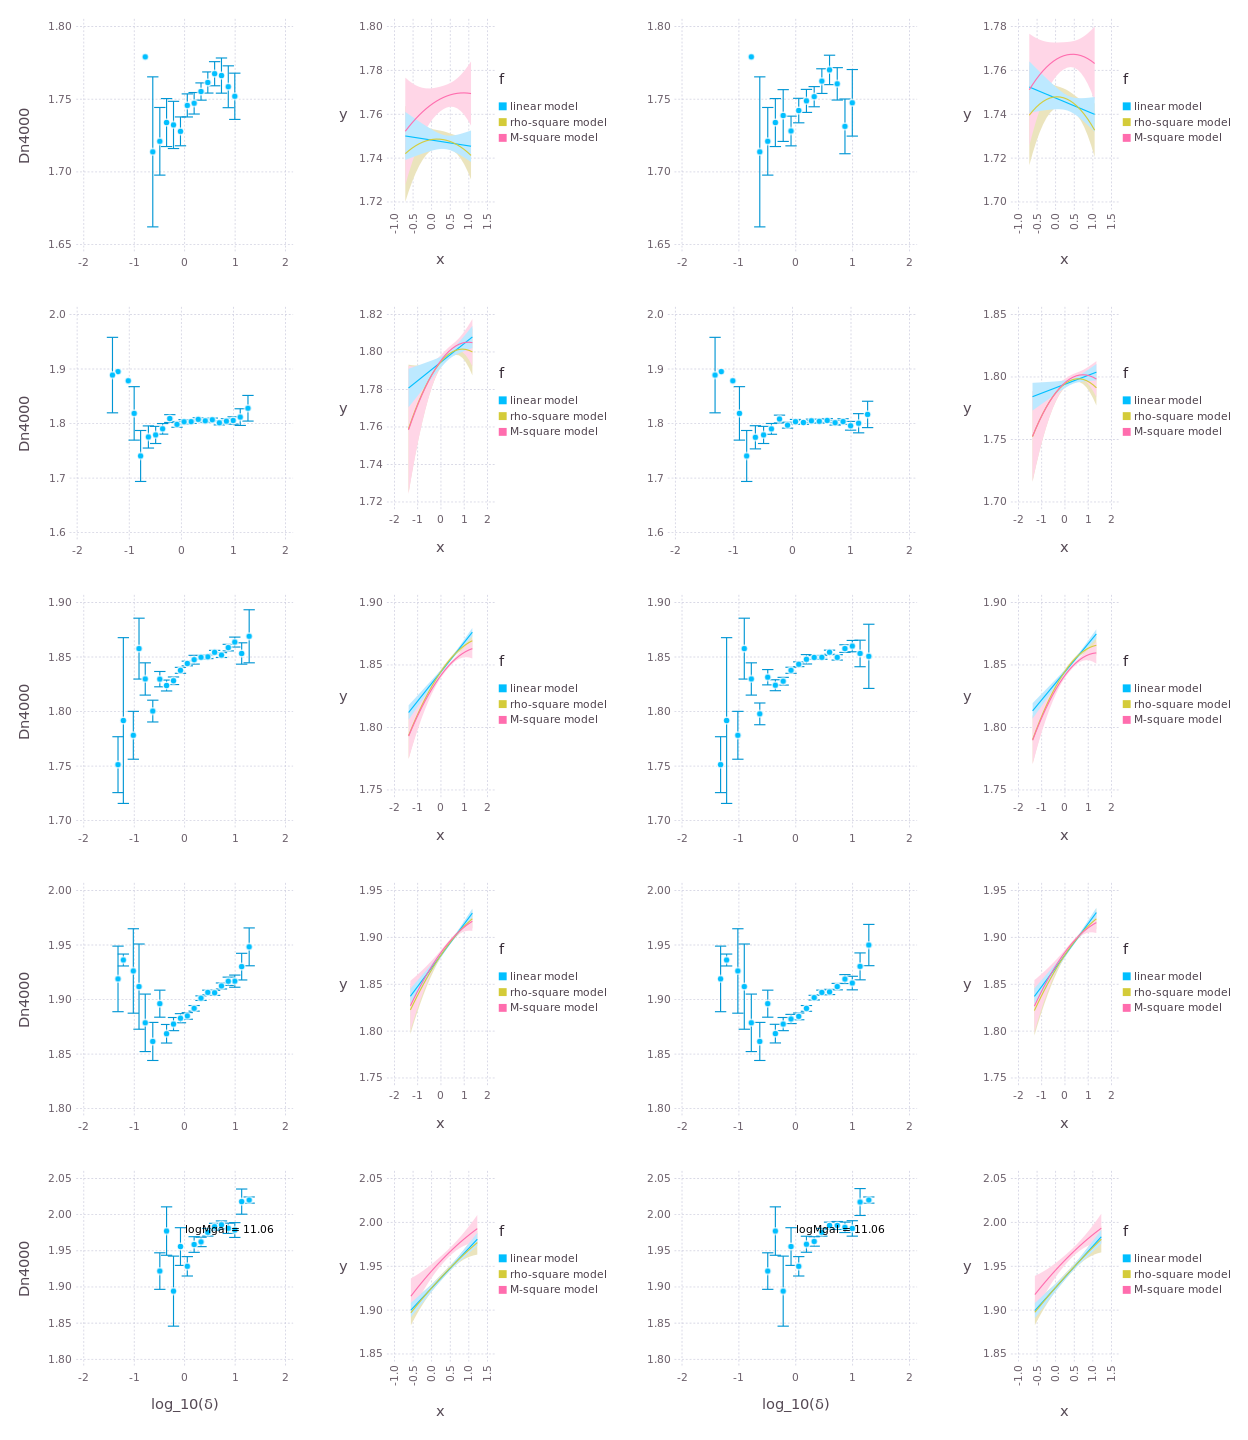

drawing...


In [34]:
# Let's start with Dn4000 again

subplots = Array{Gadfly.Plot, 1}(20)

for i in 1:nbins

    if i == nbins
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1]), :]
    else
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1]), :]
    end

    # now get the values for each bin in density
    fmeans = []
    fmins = []
    fmaxs = []
    pmeans = []
    pmins = []
    pmaxs = []
    for j in 1:nrobins
        fmean, ferr = get_errbar(subfull[:Dn4000][frobins[j] .<= subfull[:logρ] .<= frobins[j + 1]])
        pmean, perr = get_errbar(subpure[:Dn4000][probins[j] .<= subpure[:logρ] .<= probins[j + 1]])
        append!(fmeans, fmean)
        append!(fmins, fmean - ferr)
        append!(fmaxs, fmean + ferr)
        append!(pmeans, pmean)
        append!(pmins, pmean - perr)
        append!(pmaxs, pmean + perr)
    end
    
    if i == nbins
        # the full sample plots in the first two columns
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,        
                           Guide.xlabel("log_10(δ)"), Guide.ylabel("Dn4000"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 1.97,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        # leave gap for the ribbon plot using the linear model fit
      
        # and the pure sample plots in the next two columns
        subplots[i + 2 * nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                       Guide.xlabel("log_10(δ)"), Guide.ylabel(nothing),
                                       Guide.annotation(compose(context(),
                                                        Compose.text(0, 1.97,
                                                        Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
        
        
    else
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,        
                           Guide.xlabel(nothing), Guide.ylabel("Dn4000"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.97,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + 2 * nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                       Guide.xlabel(nothing), Guide.ylabel(nothing),
                                       Guide.annotation(compose(context(),
                                                        Compose.text(0, 0.97,
                                                        Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    end
    
    # ribbon plot following the gadfly example
    fxs = linspace(minimum(subfull[:logρ]), maximum(subfull[:logρ]), 20)
    pxs = linspace(minimum(subpure[:logρ]), maximum(subpure[:logρ]), 20)
    
    fsub1 = zeros(20, 4)
    fsub1[:, 1] = ones(20)
    fsub1[:, 2] = fxs
    fsub1[:, 3] = ones(20) * fullmeds[i]
    fsub1[:, 4] = fxs * fullmeds[i]
    fpred1 = predict(lmfull, Array(fsub1), :confint)
    
    df_fullmod = DataFrame(
    x=fxs,
    y=fpred1[:, 1],
    ymin=fpred1[:, 2],
    ymax=fpred1[:, 3],
    f="linear model"
    )
    
    fsub2 = zeros(20, 6)
    fsub2[:, 1] = ones(20)
    fsub2[:, 2] = fxs
    fsub2[:, 3] = ones(20) * fullmeds[i]
    fsub2[:, 4] = fxs .^ 2
    fsub2[:, 5] = fxs * fullmeds[i]
    fsub2[:, 6] = fxs .^ 2 * fullmeds[i]
    fpred2 = predict(lmfullsq, Array(fsub2), :confint)
    
    df_fullsqmod = DataFrame(
    x=fxs,
    y=fpred2[:, 1],
    ymin=fpred2[:, 2],
    ymax=fpred2[:, 3],
    f="rho-square model"
    )
    
    fsub3 = zeros(20, 8)
    fsub3[:, 1] = ones(20)
    fsub3[:, 2] = fxs
    fsub3[:, 3] = ones(20) * fullmeds[i]
    fsub3[:, 4] = fxs .^ 2
    fsub3[:, 5] = ones(20) * (fullmeds[i] ^ 2)
    fsub3[:, 6] = fxs * fullmeds[i]
    fsub3[:, 7] = fxs .^ 2 * fullmeds[i]
    fsub3[:, 8] = fxs * (fullmeds[i] ^ 2)
    fpred3 = predict(lmfulldubsq, Array(fsub3), :confint)
    
    df_fullsqdubmod = DataFrame(
    x=fxs,
    y=fpred3[:, 1],
    ymin=fpred3[:, 2],
    ymax=fpred3[:, 3],
    f="M-square model"
    )
    
    df_fullstack = vcat(df_fullmod, df_fullsqmod, df_fullsqdubmod)
    subplots[i + nbins] = plot(df_fullstack, x=:x, y=:y, ymin=:ymin, ymax=:ymax, color=:f, Geom.line, Geom.ribbon)
    
    psub1 = zeros(20, 4)
    psub1[:, 1] = ones(20)
    psub1[:, 2] = pxs
    psub1[:, 3] = ones(20) * puremeds[i]
    psub1[:, 4] = pxs * puremeds[i]
    ppred1 = predict(lmpure, Array(psub1), :confint)
    
    df_puremod = DataFrame(
    x=pxs,
    y=ppred1[:, 1],
    ymin=ppred1[:, 2],
    ymax=ppred1[:, 3],
    f="linear model"
    )
    
    psub2 = zeros(20, 6)
    psub2[:, 1] = ones(20)
    psub2[:, 2] = pxs
    psub2[:, 3] = ones(20) * puremeds[i]
    psub2[:, 4] = pxs .^ 2
    psub2[:, 5] = pxs * puremeds[i]
    psub2[:, 6] = pxs .^ 2 * puremeds[i]
    ppred2 = predict(lmpuresq, Array(psub2), :confint)
 
    
    df_puresqmod = DataFrame(
    x=pxs,
    y=ppred2[:, 1],
    ymin=ppred2[:, 2],
    ymax=ppred2[:, 3],
    f="rho-square model"
    )
    
    psub3 = zeros(20, 8)
    psub3[:, 1] = ones(20)
    psub3[:, 2] = pxs
    psub3[:, 3] = ones(20) * puremeds[i]
    psub3[:, 4] = pxs .^ 2
    psub3[:, 5] = ones(20) * (puremeds[i] ^ 2)
    psub3[:, 6] = pxs * puremeds[i]
    psub3[:, 7] = pxs .^ 2 * puremeds[i]
    psub3[:, 8] = pxs * (puremeds[i] ^ 2)
    ppred3 = predict(lmpuredubsq, Array(psub3), :confint)
    
    df_puresqdubmod = DataFrame(
    x=pxs,
    y=ppred3[:, 1],
    ymin=ppred3[:, 2],
    ymax=ppred3[:, 3],
    f="M-square model"
    )
    
    df_purestack = vcat(df_puremod, df_puresqmod, df_puresqdubmod)
    subplots[i + 3 * nbins] = plot(df_purestack, x=:x, y=:y, ymin=:ymin, ymax=:ymax, color=:f, Geom.line, Geom.ribbon)
end

println("stacking...")
fig = hstack(vstack(subplots[1:5]), vstack(subplots[6:10]), vstack(subplots[11:15]), vstack(subplots[16:20]))
println("drawing...")
draw(PNG("ribbons_errbar_Dn4k_v_rho.png", 13inch, 15inch), fig)
display("image/png", read("ribbons_errbar_Dn4k_v_rho.png"))



In [36]:
lmfull = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
                 Estimate   Std.Error  t value Pr(>|t|)
(Intercept)    -0.0608253   0.0015721 -38.6904   <1e-99
logρ            -0.022101  0.00309279 -7.14596   <1e-12
log10M         0.00636791 0.000151004  42.1705   <1e-99
logρ & log10M  0.00214839 0.000296944    7.235   <1e-12


In [38]:
lmpure = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
                 Estimate   Std.Error  t value Pr(>|t|)
(Intercept)    -0.0613116  0.00164676 -37.2316   <1e-99
logρ           -0.0264226  0.00332823 -7.93894   <1e-14
log10M         0.00641275 0.000158101  40.5612   <1e-99
logρ & log10M  0.00256713 0.000319228  8.04168   <1e-15


In [43]:
lmfullsq = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                   Estimate   Std.Error   t value Pr(>|t|)
(Intercept)      -0.0608222  0.00157336  -38.6576   <1e-99
logρ             -0.0199257  0.00527559  -3.77696   0.0002
log10M           0.00636804  0.00015112   42.1391   <1e-99
logρ2           -0.00330182  0.00633505 -0.521199   0.6022
logρ & log10M    0.00194785 0.000506774   3.84363   0.0001
log10M & logρ2   0.00030273   0.0006084  0.497584   0.6188


In [44]:
lmpuresq = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                   Estimate   Std.Error  t value Pr(>|t|)
(Intercept)      -0.0612568  0.00164798 -37.1709   <1e-99
logρ             -0.0221629  0.00545591 -4.06218    <1e-4
log10M           0.00640797 0.000158196  40.5066   <1e-99
logρ2           -0.00678872  0.00676053 -1.00417   0.3153
logρ & log10M    0.00216302 0.000523929  4.12846    <1e-4
log10M & logρ2   0.00064241  0.00064871 0.990288   0.3220


In [45]:
lmfulldubsq = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                  Estimate   Std.Error   t value Pr(>|t|)
(Intercept)       0.301598   0.0389764   7.73796   <1e-13
logρ              0.593981   0.0753731   7.88054   <1e-14
log10M           -0.063924  0.00755207  -8.46443   <1e-16
logρ2           0.00553134  0.00636438   0.86911   0.3848
logM2           0.00340583  0.00036571   9.31294   <1e-19
logρ & log10M    -0.116326   0.0146121  -7.96092   <1e-14
log10M & logρ2  -0.0005592 0.000611495 -0.914481   0.3605
logρ & logM2    0.00569201  0.00070861   8.03263   <1e-15


In [46]:
lmpuredubsq = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                    Estimate   Std.Error   t value Pr(>|t|)
(Intercept)         0.311713   0.0409973   7.60325   <1e-13
logρ                0.640394   0.0816257    7.8455   <1e-14
log10M            -0.0658977  0.00793744  -8.30214   <1e-15
logρ2             0.00646703  0.00683878   0.94564   0.3443
logM2             0.00350186 0.000384077   9.11761   <1e-19
logρ & log10M      -0.125322   0.0158182  -7.92261   <1e-14
log10M & logρ2  -0.000644645 0.000656612 -0.981774   0.3262
logρ & logM2      0.00612762 0.000766732   7.99186   <1e-14


In [50]:
cor(fulldf[:R_e], fulldf[:log10M])

0.3065876563568759

stacking...


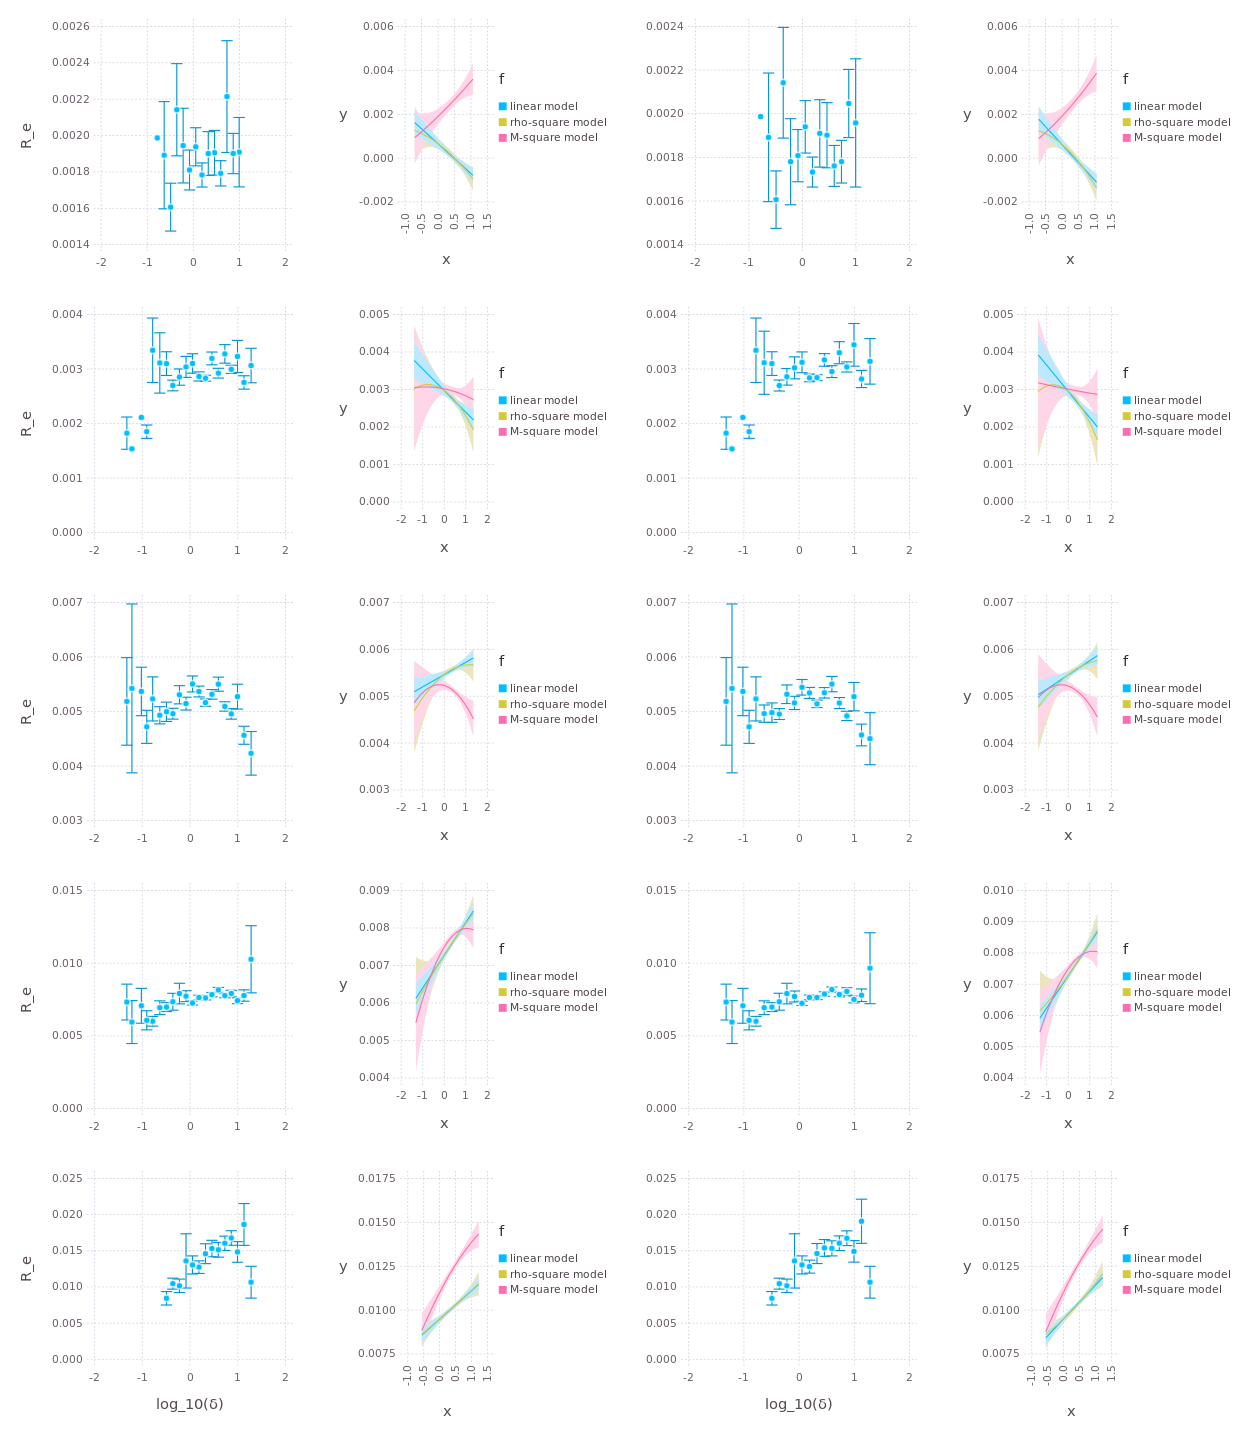

drawing...


In [47]:
# R_e

subplots = Array{Gadfly.Plot, 1}(20)

for i in 1:nbins

    if i == nbins
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1]), :]
    else
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1]), :]
    end

    # now get the values for each bin in density
    fmeans = []
    fmins = []
    fmaxs = []
    pmeans = []
    pmins = []
    pmaxs = []
    for j in 1:nrobins
        fmean, ferr = get_errbar(subfull[:R_e][frobins[j] .<= subfull[:logρ] .<= frobins[j + 1]])
        pmean, perr = get_errbar(subpure[:R_e][probins[j] .<= subpure[:logρ] .<= probins[j + 1]])
        append!(fmeans, fmean)
        append!(fmins, fmean - ferr)
        append!(fmaxs, fmean + ferr)
        append!(pmeans, pmean)
        append!(pmins, pmean - perr)
        append!(pmaxs, pmean + perr)
    end
    
    if i == nbins
        # the full sample plots in the first two columns
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,        
                           Guide.xlabel("log_10(δ)"), Guide.ylabel("R_e"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 1.97,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        # leave gap for the ribbon plot using the linear model fit
      
        # and the pure sample plots in the next two columns
        subplots[i + 2 * nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                       Guide.xlabel("log_10(δ)"), Guide.ylabel(nothing),
                                       Guide.annotation(compose(context(),
                                                        Compose.text(0, 1.97,
                                                        Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
        
        
    else
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,        
                           Guide.xlabel(nothing), Guide.ylabel("R_e"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.97,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + 2 * nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                       Guide.xlabel(nothing), Guide.ylabel(nothing),
                                       Guide.annotation(compose(context(),
                                                        Compose.text(0, 0.97,
                                                        Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    end
    
    # ribbon plot following the gadfly example
    fxs = linspace(minimum(subfull[:logρ]), maximum(subfull[:logρ]), 20)
    pxs = linspace(minimum(subpure[:logρ]), maximum(subpure[:logρ]), 20)
    
    fsub1 = zeros(20, 4)
    fsub1[:, 1] = ones(20)
    fsub1[:, 2] = fxs
    fsub1[:, 3] = ones(20) * fullmeds[i]
    fsub1[:, 4] = fxs * fullmeds[i]
    fpred1 = predict(lmfull, Array(fsub1), :confint)
    
    df_fullmod = DataFrame(
    x=fxs,
    y=fpred1[:, 1],
    ymin=fpred1[:, 2],
    ymax=fpred1[:, 3],
    f="linear model"
    )
    
    fsub2 = zeros(20, 6)
    fsub2[:, 1] = ones(20)
    fsub2[:, 2] = fxs
    fsub2[:, 3] = ones(20) * fullmeds[i]
    fsub2[:, 4] = fxs .^ 2
    fsub2[:, 5] = fxs * fullmeds[i]
    fsub2[:, 6] = fxs .^ 2 * fullmeds[i]
    fpred2 = predict(lmfullsq, Array(fsub2), :confint)
    
    df_fullsqmod = DataFrame(
    x=fxs,
    y=fpred2[:, 1],
    ymin=fpred2[:, 2],
    ymax=fpred2[:, 3],
    f="rho-square model"
    )
    
    fsub3 = zeros(20, 8)
    fsub3[:, 1] = ones(20)
    fsub3[:, 2] = fxs
    fsub3[:, 3] = ones(20) * fullmeds[i]
    fsub3[:, 4] = fxs .^ 2
    fsub3[:, 5] = ones(20) * (fullmeds[i] ^ 2)
    fsub3[:, 6] = fxs * fullmeds[i]
    fsub3[:, 7] = fxs .^ 2 * fullmeds[i]
    fsub3[:, 8] = fxs * (fullmeds[i] ^ 2)
    fpred3 = predict(lmfulldubsq, Array(fsub3), :confint)
    
    df_fullsqdubmod = DataFrame(
    x=fxs,
    y=fpred3[:, 1],
    ymin=fpred3[:, 2],
    ymax=fpred3[:, 3],
    f="M-square model"
    )
    
    df_fullstack = vcat(df_fullmod, df_fullsqmod, df_fullsqdubmod)
    subplots[i + nbins] = plot(df_fullstack, x=:x, y=:y, ymin=:ymin, ymax=:ymax, color=:f, Geom.line, Geom.ribbon)
    
    psub1 = zeros(20, 4)
    psub1[:, 1] = ones(20)
    psub1[:, 2] = pxs
    psub1[:, 3] = ones(20) * puremeds[i]
    psub1[:, 4] = pxs * puremeds[i]
    ppred1 = predict(lmpure, Array(psub1), :confint)
    
    df_puremod = DataFrame(
    x=pxs,
    y=ppred1[:, 1],
    ymin=ppred1[:, 2],
    ymax=ppred1[:, 3],
    f="linear model"
    )
    
    psub2 = zeros(20, 6)
    psub2[:, 1] = ones(20)
    psub2[:, 2] = pxs
    psub2[:, 3] = ones(20) * puremeds[i]
    psub2[:, 4] = pxs .^ 2
    psub2[:, 5] = pxs * puremeds[i]
    psub2[:, 6] = pxs .^ 2 * puremeds[i]
    ppred2 = predict(lmpuresq, Array(psub2), :confint)
 
    
    df_puresqmod = DataFrame(
    x=pxs,
    y=ppred2[:, 1],
    ymin=ppred2[:, 2],
    ymax=ppred2[:, 3],
    f="rho-square model"
    )
    
    psub3 = zeros(20, 8)
    psub3[:, 1] = ones(20)
    psub3[:, 2] = pxs
    psub3[:, 3] = ones(20) * puremeds[i]
    psub3[:, 4] = pxs .^ 2
    psub3[:, 5] = ones(20) * (puremeds[i] ^ 2)
    psub3[:, 6] = pxs * puremeds[i]
    psub3[:, 7] = pxs .^ 2 * puremeds[i]
    psub3[:, 8] = pxs * (puremeds[i] ^ 2)
    ppred3 = predict(lmpuredubsq, Array(psub3), :confint)
    
    df_puresqdubmod = DataFrame(
    x=pxs,
    y=ppred3[:, 1],
    ymin=ppred3[:, 2],
    ymax=ppred3[:, 3],
    f="M-square model"
    )
    
    df_purestack = vcat(df_puremod, df_puresqmod, df_puresqdubmod)
    subplots[i + 3 * nbins] = plot(df_purestack, x=:x, y=:y, ymin=:ymin, ymax=:ymax, color=:f, Geom.line, Geom.ribbon)
end

println("stacking...")
fig = hstack(vstack(subplots[1:5]), vstack(subplots[6:10]), vstack(subplots[11:15]), vstack(subplots[16:20]))
println("drawing...")
draw(PNG("ribbons_errbar_R_e_v_rho.png", 13inch, 15inch), fig)
display("image/png", read("ribbons_errbar_R_e_v_rho.png"))


In [52]:
lmfull = fit(LinearModel, @formula(sersic ~ logρ + log10M + logρ&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: sersic ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
               Estimate Std.Error  t value Pr(>|t|)
(Intercept)    -7.61301  0.380397 -20.0133   <1e-88
logρ           -2.23976  0.748354 -2.99292   0.0028
log10M          1.16139  0.036538  31.7857   <1e-99
logρ & log10M  0.222096 0.0718508  3.09107   0.0020


In [54]:
lmpure = fit(LinearModel, @formula(sersic ~ logρ + log10M + logρ&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: sersic ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
               Estimate Std.Error  t value Pr(>|t|)
(Intercept)    -7.72684  0.393119 -19.6552   <1e-84
logρ           -2.24849  0.794523 -2.82998   0.0047
log10M          1.17182 0.0377422  31.0479   <1e-99
logρ & log10M  0.223448 0.0762069  2.93212   0.0034


In [55]:
lmfullsq = fit(LinearModel, @formula(sersic ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: sersic ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                 Estimate Std.Error  t value Pr(>|t|)
(Intercept)      -7.57335  0.380664 -19.8951   <1e-87
logρ             -3.37113    1.2764 -2.64113   0.0083
log10M            1.15787 0.0365624  31.6684   <1e-99
logρ2             1.61134   1.53273  1.05129   0.2931
logρ & log10M    0.337867  0.122611  2.75561   0.0059
log10M & logρ2  -0.166849  0.147199 -1.13349   0.2570


In [56]:
lmpuresq = fit(LinearModel, @formula(sersic ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: sersic ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                 Estimate Std.Error  t value Pr(>|t|)
(Intercept)      -7.68877  0.393373 -19.5458   <1e-84
logρ             -3.43763   1.30233 -2.63961   0.0083
log10M            1.16856 0.0377613   30.946   <1e-99
logρ2              1.6906   1.61374  1.04763   0.2948
logρ & log10M    0.344267  0.125062  2.75277   0.0059
log10M & logρ2  -0.174271  0.154847 -1.12544   0.2604


In [57]:
lmfulldubsq = fit(LinearModel, @formula(sersic ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: sersic ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                 Estimate Std.Error   t value Pr(>|t|)
(Intercept)       57.6261    9.4849   6.07556    <1e-8
logρ             -43.0894    18.342  -2.34922   0.0188
log10M           -11.4842   1.83779  -6.24891    <1e-9
logρ2             1.20622   1.54877  0.778822   0.4361
logM2            0.612379 0.0889953   6.88103   <1e-11
logρ & log10M     8.12826   3.55585   2.28589   0.0223
log10M & logρ2  -0.126836  0.148807 -0.852352   0.3940
logρ & logM2     -0.38176   0.17244  -2.21387   0.0268


In [58]:
lmpuredubsq = fit(LinearModel, @formula(sersic ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: sersic ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                 Estimate Std.Error   t value Pr(>|t|)
(Intercept)       57.1008   9.84282   5.80127    <1e-8
logρ             -35.5192   19.5971  -1.81248   0.0699
log10M           -11.3857   1.90566  -5.97467    <1e-8
logρ2             1.42112   1.64189  0.865543   0.3867
logM2            0.607727 0.0922109   6.59062   <1e-10
logρ & log10M     6.66496   3.79771     1.755   0.0793
log10M & logρ2  -0.147432  0.157643 -0.935232   0.3497
logρ & logM2    -0.311093  0.184081  -1.68998   0.0910


stacking...


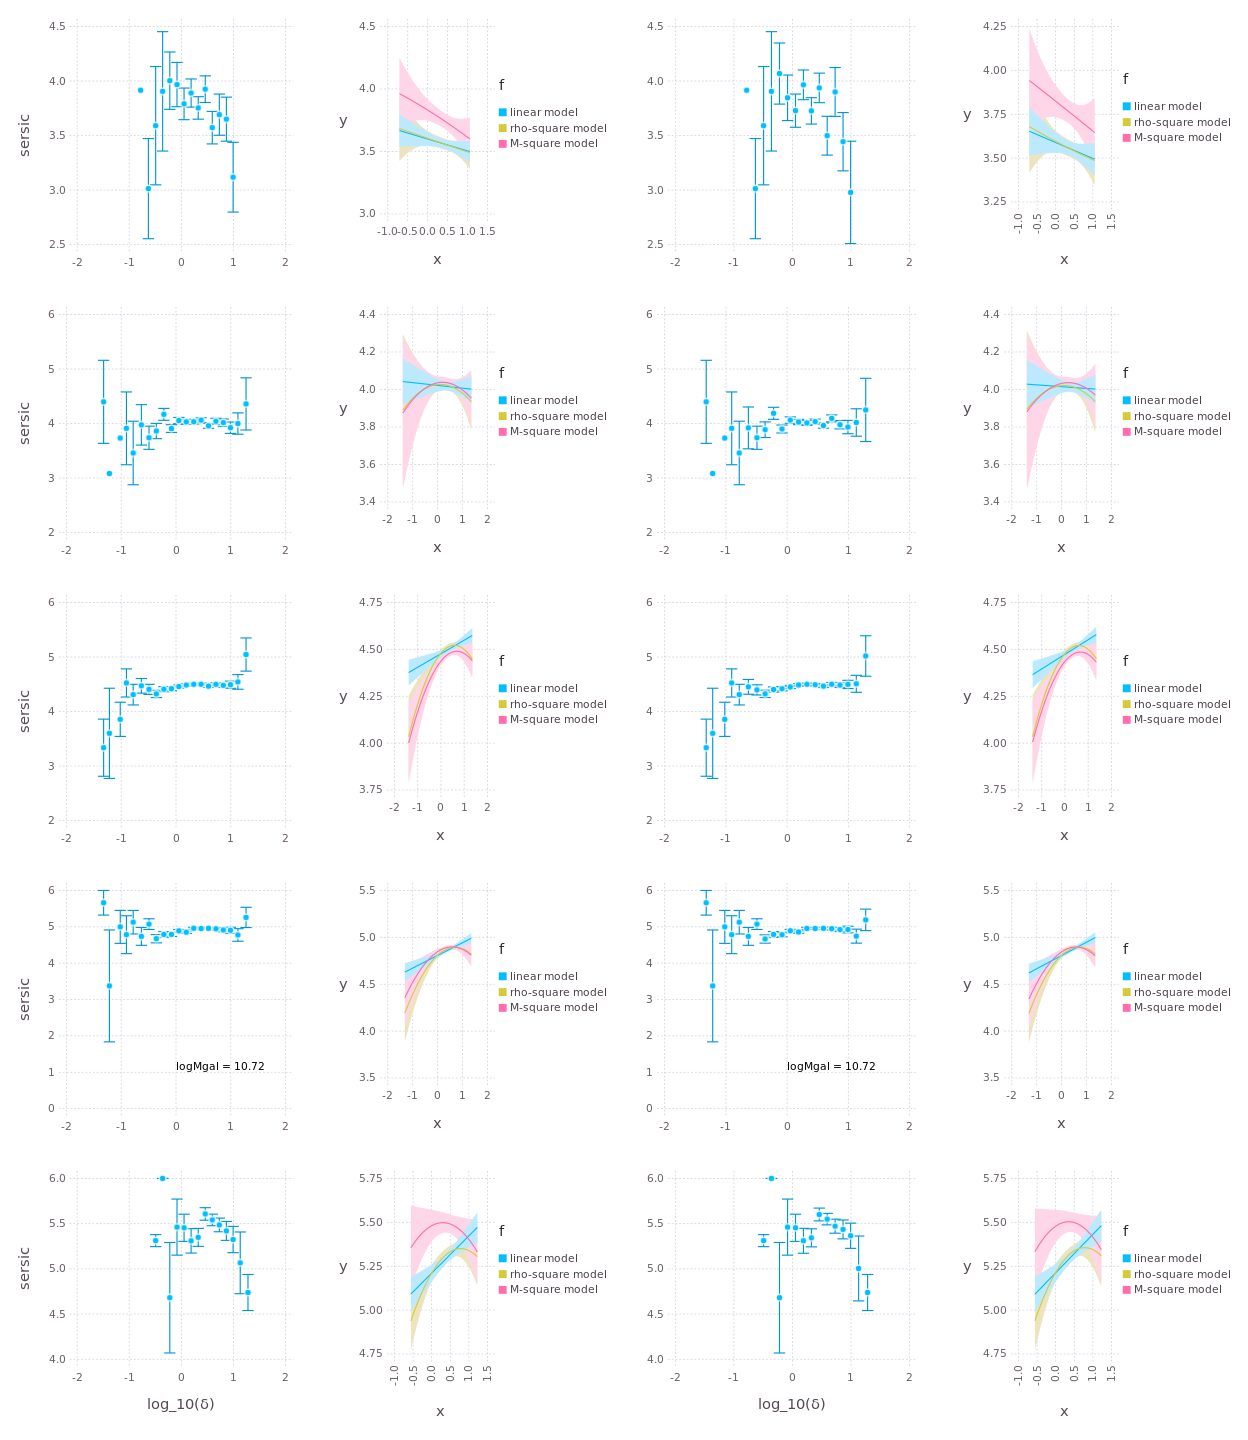

drawing...


In [59]:
# Giving sersic index a shot

subplots = Array{Gadfly.Plot, 1}(20)

for i in 1:nbins

    if i == nbins
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1]), :]
    else
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1]), :]
    end

    # now get the values for each bin in density
    fmeans = []
    fmins = []
    fmaxs = []
    pmeans = []
    pmins = []
    pmaxs = []
    for j in 1:nrobins
        fmean, ferr = get_errbar(subfull[:sersic][frobins[j] .<= subfull[:logρ] .<= frobins[j + 1]])
        pmean, perr = get_errbar(subpure[:sersic][probins[j] .<= subpure[:logρ] .<= probins[j + 1]])
        append!(fmeans, fmean)
        append!(fmins, fmean - ferr)
        append!(fmaxs, fmean + ferr)
        append!(pmeans, pmean)
        append!(pmins, pmean - perr)
        append!(pmaxs, pmean + perr)
    end
    
    if i == nbins
        # the full sample plots in the first two columns
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,        
                           Guide.xlabel("log_10(δ)"), Guide.ylabel("sersic"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 1.97,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        # leave gap for the ribbon plot using the linear model fit
      
        # and the pure sample plots in the next two columns
        subplots[i + 2 * nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                       Guide.xlabel("log_10(δ)"), Guide.ylabel(nothing),
                                       Guide.annotation(compose(context(),
                                                        Compose.text(0, 1.97,
                                                        Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
        
        
    else
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,        
                           Guide.xlabel(nothing), Guide.ylabel("sersic"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.97,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + 2 * nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                       Guide.xlabel(nothing), Guide.ylabel(nothing),
                                       Guide.annotation(compose(context(),
                                                        Compose.text(0, 0.97,
                                                        Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    end
    
    # ribbon plot following the gadfly example
    fxs = linspace(minimum(subfull[:logρ]), maximum(subfull[:logρ]), 20)
    pxs = linspace(minimum(subpure[:logρ]), maximum(subpure[:logρ]), 20)
    
    fsub1 = zeros(20, 4)
    fsub1[:, 1] = ones(20)
    fsub1[:, 2] = fxs
    fsub1[:, 3] = ones(20) * fullmeds[i]
    fsub1[:, 4] = fxs * fullmeds[i]
    fpred1 = predict(lmfull, Array(fsub1), :confint)
    
    df_fullmod = DataFrame(
    x=fxs,
    y=fpred1[:, 1],
    ymin=fpred1[:, 2],
    ymax=fpred1[:, 3],
    f="linear model"
    )
    
    fsub2 = zeros(20, 6)
    fsub2[:, 1] = ones(20)
    fsub2[:, 2] = fxs
    fsub2[:, 3] = ones(20) * fullmeds[i]
    fsub2[:, 4] = fxs .^ 2
    fsub2[:, 5] = fxs * fullmeds[i]
    fsub2[:, 6] = fxs .^ 2 * fullmeds[i]
    fpred2 = predict(lmfullsq, Array(fsub2), :confint)
    
    df_fullsqmod = DataFrame(
    x=fxs,
    y=fpred2[:, 1],
    ymin=fpred2[:, 2],
    ymax=fpred2[:, 3],
    f="rho-square model"
    )
    
    fsub3 = zeros(20, 8)
    fsub3[:, 1] = ones(20)
    fsub3[:, 2] = fxs
    fsub3[:, 3] = ones(20) * fullmeds[i]
    fsub3[:, 4] = fxs .^ 2
    fsub3[:, 5] = ones(20) * (fullmeds[i] ^ 2)
    fsub3[:, 6] = fxs * fullmeds[i]
    fsub3[:, 7] = fxs .^ 2 * fullmeds[i]
    fsub3[:, 8] = fxs * (fullmeds[i] ^ 2)
    fpred3 = predict(lmfulldubsq, Array(fsub3), :confint)
    
    df_fullsqdubmod = DataFrame(
    x=fxs,
    y=fpred3[:, 1],
    ymin=fpred3[:, 2],
    ymax=fpred3[:, 3],
    f="M-square model"
    )
    
    df_fullstack = vcat(df_fullmod, df_fullsqmod, df_fullsqdubmod)
    subplots[i + nbins] = plot(df_fullstack, x=:x, y=:y, ymin=:ymin, ymax=:ymax, color=:f, Geom.line, Geom.ribbon)
    
    psub1 = zeros(20, 4)
    psub1[:, 1] = ones(20)
    psub1[:, 2] = pxs
    psub1[:, 3] = ones(20) * puremeds[i]
    psub1[:, 4] = pxs * puremeds[i]
    ppred1 = predict(lmpure, Array(psub1), :confint)
    
    df_puremod = DataFrame(
    x=pxs,
    y=ppred1[:, 1],
    ymin=ppred1[:, 2],
    ymax=ppred1[:, 3],
    f="linear model"
    )
    
    psub2 = zeros(20, 6)
    psub2[:, 1] = ones(20)
    psub2[:, 2] = pxs
    psub2[:, 3] = ones(20) * puremeds[i]
    psub2[:, 4] = pxs .^ 2
    psub2[:, 5] = pxs * puremeds[i]
    psub2[:, 6] = pxs .^ 2 * puremeds[i]
    ppred2 = predict(lmpuresq, Array(psub2), :confint)
 
    
    df_puresqmod = DataFrame(
    x=pxs,
    y=ppred2[:, 1],
    ymin=ppred2[:, 2],
    ymax=ppred2[:, 3],
    f="rho-square model"
    )
    
    psub3 = zeros(20, 8)
    psub3[:, 1] = ones(20)
    psub3[:, 2] = pxs
    psub3[:, 3] = ones(20) * puremeds[i]
    psub3[:, 4] = pxs .^ 2
    psub3[:, 5] = ones(20) * (puremeds[i] ^ 2)
    psub3[:, 6] = pxs * puremeds[i]
    psub3[:, 7] = pxs .^ 2 * puremeds[i]
    psub3[:, 8] = pxs * (puremeds[i] ^ 2)
    ppred3 = predict(lmpuredubsq, Array(psub3), :confint)
    
    df_puresqdubmod = DataFrame(
    x=pxs,
    y=ppred3[:, 1],
    ymin=ppred3[:, 2],
    ymax=ppred3[:, 3],
    f="M-square model"
    )
    
    df_purestack = vcat(df_puremod, df_puresqmod, df_puresqdubmod)
    subplots[i + 3 * nbins] = plot(df_purestack, x=:x, y=:y, ymin=:ymin, ymax=:ymax, color=:f, Geom.line, Geom.ribbon)
end

println("stacking...")
fig = hstack(vstack(subplots[1:5]), vstack(subplots[6:10]), vstack(subplots[11:15]), vstack(subplots[16:20]))
println("drawing...")
draw(PNG("ribbons_errbar_sersic_v_rho.png", 13inch, 15inch), fig)
display("image/png", read("ribbons_errbar_sersic_v_rho.png"))
